In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()


4422102/4422102 [==============================] - 0s 0us/step


In [3]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.



In [4]:
x_train = x_train[..., tf.newaxis] #adds a additional axis (60000,28,28) --> (60000,28,28,1)
x_test = x_test[..., tf.newaxis]
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [5]:
tf.random.normal(shape=x_train.shape)

<tf.Tensor: shape=(60000, 28, 28, 1), dtype=float32, numpy=
array([[[[-2.32286119e+00],
         [ 9.47126985e-01],
         [-6.42473578e-01],
         ...,
         [-1.01822281e+00],
         [-7.91058838e-01],
         [-1.16858281e-01]],

        [[-5.96542120e-01],
         [ 2.05517364e+00],
         [ 2.36332595e-01],
         ...,
         [-1.37737048e+00],
         [ 3.87769967e-01],
         [ 1.23531103e+00]],

        [[ 3.12172562e-01],
         [ 1.73765719e+00],
         [-1.42393458e+00],
         ...,
         [ 1.30325961e+00],
         [-1.36330223e+00],
         [-3.53413194e-01]],

        ...,

        [[-2.96911120e-01],
         [-1.13505101e+00],
         [ 6.65030062e-01],
         ...,
         [ 1.45418569e-01],
         [-1.00054455e+00],
         [-1.10665463e-01]],

        [[-1.12573731e+00],
         [-6.70731485e-01],
         [-8.10570121e-01],
         ...,
         [ 6.46248281e-01],
         [-2.77085900e-01],
         [-8.40362966e-01]],

      

In [6]:
noise_factor = 0.2
x_train_noisy = x_train  +  noise_factor * tf.random.normal(shape=x_train.shape)
# noise factor multiplication result in increased spread in noise distribution
# result in 0.2^2 increase of variance, mean doesn't chnage (mean = 0)
x_test_noisy = x_test  +  noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

In [7]:
x_test_noisy.shape

TensorShape([10000, 28, 28, 1])

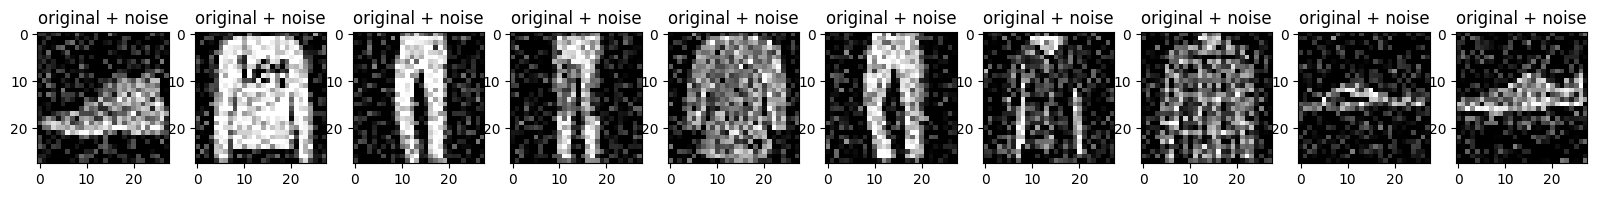

In [8]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

In [9]:
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = tf.keras.Sequential([
          layers.Input(shape=(28, 28, 1)),
          layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
          layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

        self.decoder = tf.keras.Sequential([
          layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
          layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
          layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [10]:
autoencoder = Denoise()

In [11]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [13]:
history = autoencoder.fit(x_train_noisy, x_train,
                epochs=30,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/30
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0129 - val_loss: 0.0104
Epoch 2/30
1875/1875 [==============================] - 31s 17ms/step - loss: 0.0097 - val_loss: 0.0092
Epoch 3/30
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0088 - val_loss: 0.0085
Epoch 4/30
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0083 - val_loss: 0.0081
Epoch 5/30
1875/1875 [==============================] - 31s 17ms/step - loss: 0.0080 - val_loss: 0.0080
Epoch 6/30
1875/1875 [==============================] - 31s 16ms/step - loss: 0.0079 - val_loss: 0.0078
Epoch 7/30
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0077 - val_loss: 0.0077
Epoch 8/30
1875/1875 [==============================] - 31s 16ms/step - loss: 0.0076 - val_loss: 0.0076
Epoch 9/30
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0076 - val_loss: 0.0075
Epoch 10/30
1875/1875 [==============================] - 30s 16m

In [14]:
import tensorflow as tf

model = Denoise()
x_test_reshaped = tf.reshape(x_test, (x_test.shape[0], 28, 28, 1))
reconstructed_images = model(x_test_reshaped)
mse_loss = tf.keras.losses.MeanSquaredError()(x_test_reshaped, reconstructed_images)
average_mse_loss = tf.reduce_mean(mse_loss)

print("Average MSE Loss on Test Data:", average_mse_loss.numpy())


Average MSE Loss on Test Data: 0.1696104


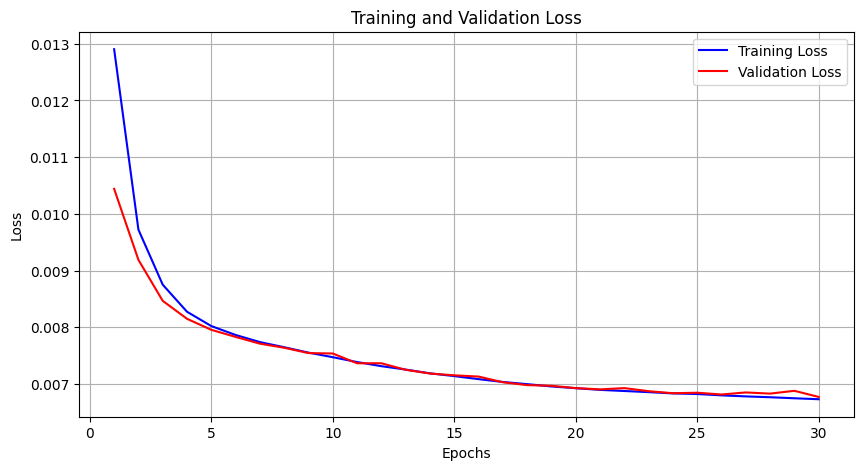

In [17]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a range of epoch numbers for the x-axis
epochs = range(1, 30 + 1)

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [15]:
autoencoder.encoder.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1320 (5.16 KB)
Trainable params: 1320 (5.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
autoencoder.decoder.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTr  (None, 14, 14, 8)         584       
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 16)        1168      
 Transpose)                                                      
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         145       
                                                                 
Total params: 1897 (7.41 KB)
Trainable params: 1897 (7.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

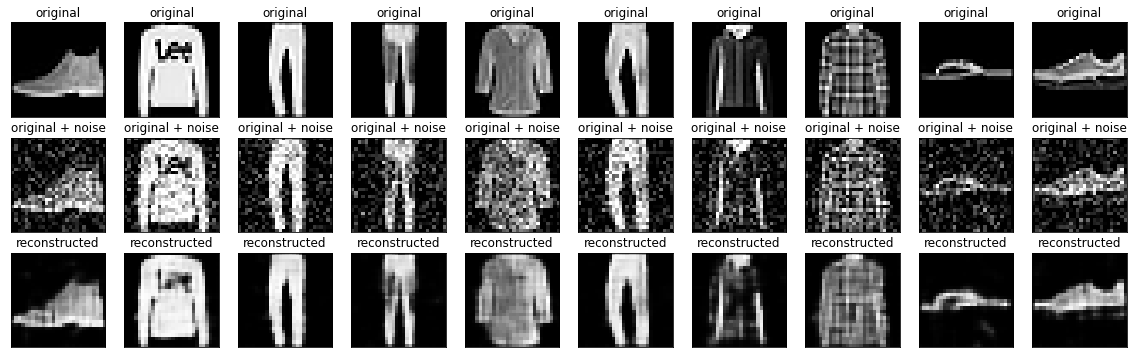

In [ ]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(x_test[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display original + noise
    ax = plt.subplot(3, n, i + n + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(3, n, i + 2*n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()